In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style as mpl
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization
from sklearn.utils import shuffle
import datetime
import visualkeras
import gc

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [4]:
import tensorflow as tf
%load_ext tensorboard

In [5]:
%matplotlib inline
mpl.use('seaborn')

In [6]:
mn2 = 1000
prop_seed = 345
train_div = 0.5
back_callback_dir = "/home2/kalp_shah/neutrino/codes/ml/backup/autoenc"
log_folder = "logs/autoenc"
model_dir = "/home2/kalp_shah/neutrino/datasets/model/"
sig_epoch = {'test' : [], 'complete' : []}
max_sig = 0

In [7]:
!rm -rf /home2/kalp_shah/neutrino/codes/ml/backup/autoenc
!rm -rf logs/autoenc

In [8]:
n2n2_cs = {500  : 5.13*1e-4,
           750  : 3.83*1e-4,
           1000 : 2.42*1e-4,
           1250 : 9.56*1e-5,
           1400 : 4.74*1e-5}

In [9]:
cs_lo_k = { 'ttbar':988.57,
            'wmp'  :1.95*1e5,
            'wpwm' :124.31,
            'zwpm' :51.82,
            'n2n2' :1}

br_ratio = {'ttbar':0.67*(1-0.67)*2,
            'wmp'  :(1-0.67),
            'wpwm' :(1-0.67)*0.67*2,
            'zwpm' :0.7*(1-0.67),
            'n2n2' :1}

cs_nmg = {  'ttbar':393.30,
            'wmp'  :7.865*1e4,
            'wpwm' :74.96,
            'zwpm' :14.28,
            'n2n2' :1}

cs_mg = {   'ttbar':5.883,
            'wmp':111.5,
            'wpwm':0.944,
            'zwpm':0.2381,
            'n2n2':n2n2_cs[mn2]}

In [10]:
files = ['ttbar','wmp','wpwm','zwpm','n2n2']

# The cross sections are given in picobarn
cs_pb = []
for f in files:
    cs_pb.append((cs_lo_k[f]*br_ratio[f]*cs_mg[f])/cs_nmg[f])

cs = [i*1e3 for i in cs_pb]
cs_corr = {files[i] : cs[i] for i in range(len(files))}

In [11]:
cs_print = pd.DataFrame([cs_corr.keys(),cs_corr.values()]).T
cs_print.rename(columns = {0:'Process',1:'Cross section (fb)'}, inplace = True)

In [12]:
cs_print.style.hide_index()

Process,Cross section (fb)
ttbar,6538.845366
wmp,91227.272727
wpwm,692.256785
zwpm,199.590826
n2n2,0.242000


In [13]:
no_of_files = {'ttbar':0,
               'wmp':0,
               'wpwm':0,
               'zwpm':0,
               'n2n2':0
               }

In [14]:
df = []
for f in range(len(files)):
    con_df = []
    
    # The maximum file number 
    for i in range(1,80):
        try:
            if files[f] == 'n2n2':
                con_df.append(pd.read_csv('~/neutrino/datasets/n2n2_' + str(mn2) + '/' + files[f] + str(i) + '.csv'))
            else:
                con_df.append(pd.read_csv('~/neutrino/datasets/backgrounds/' + files[f] + str(i) + '.csv'))
            no_of_files[files[f]] += 1
        except:
            pass
    
    df.append(pd.concat(con_df,ignore_index=True))
    df[-1]['type'] = f
    
    if files[f] == "n2n2":
        df[-1]['tag'] = 1
    else:
        df[-1]['tag'] = 0

In [15]:
red_merging = {'ttbar':98159,
               'wmp':96494,
               'wpwm':97633,
               'zwpm':81076,
               'n2n2':int(1e5)
               }

In [16]:
total_events = []

for f in range(len(files)):
    total_events.append(no_of_files[files[f]] * red_merging[files[f]])

In [17]:
nf_print = pd.DataFrame([no_of_files.keys(),total_events]).T
nf_print.rename(columns = {0:'Process',1:'Number of Events'}, inplace = True)

In [18]:
nf_print.style.hide_index()

Process,Number of Events
ttbar,6085858
wmp,5886134
wpwm,4002953
zwpm,3648420
n2n2,6900000


In [19]:
tf.random.set_seed(prop_seed)
np.random.seed(prop_seed)

In [20]:
for i in range(len(df)):
    df[i] = shuffle(df[i])

In [21]:
df_train = []
df_test = []
for df_sub in df:
    df_train.append(df_sub[:int(len(df_sub)/2)])
    df_test.append(df_sub[int(len(df_sub)/2):])

In [22]:
dtset = pd.concat(df,ignore_index=True)
dtset['met'] = np.fabs(dtset['met'])

dtset_train = pd.concat(df_train,ignore_index=True)
dtset_train['met'] = np.fabs(dtset_train['met'])

dtset_test = pd.concat(df_test,ignore_index=True)
dtset_test['met'] = np.fabs(dtset_test['met'])

In [23]:
dtset = dtset\
       [dtset['ptl'] >= 120.0]\
       [dtset['ptj'] >= 120.0]\
       [dtset['etaj'] <=  2.0]\
       [dtset['etaj'] >= -2.0]

In [24]:
## Analysis Level Cuts
dtset_train = dtset_train\
             [dtset_train['ptl'] >= 120.0]\
             [dtset_train['ptj'] >= 120.0]\
             [dtset_train['etaj'] <=  2.0]\
             [dtset_train['etaj'] >= -2.0]

In [25]:
## Analysis Level Cuts
dtset_test = dtset_test\
            [dtset_test['ptl'] >= 120.0]\
            [dtset_test['ptj'] >= 120.0]\
            [dtset_test['etaj'] <=  2.0]\
            [dtset_test['etaj'] >= -2.0]

In [26]:
key_dict = dtset.keys()
mins,maxs = [], []
for i in range(17):
    mins.append(max(dtset[key_dict[i]].values))
    maxs.append(min(dtset[key_dict[i]].values))

In [27]:
for i in range(17):
    dtset[key_dict[i]] = (dtset[key_dict[i]] - mins[i])/(maxs[i] - mins[i])
    dtset_test[key_dict[i]] = (dtset_test[key_dict[i]] - mins[i])/(maxs[i] - mins[i])
    dtset_train[key_dict[i]] = (dtset_train[key_dict[i]] - mins[i])/(maxs[i] - mins[i])

In [28]:
dtset.head()

,ptl,etal,energyl,ptj,etaj,energyj,massj,mjj,rjj,rjl,met,n21_1,n21_2,n32_1,n32_2,infl,drfl,type,tag
0,0.996299,0.299338,0.982693,0.980478,0.546813,0.985510,0.951563,0.953633,0.378069,0.357056,0.956076,0.627949,0.563526,0.721606,0.913121,0.982171,0.752706,0,0
2,0.971455,0.312541,0.969979,0.936907,0.772690,0.912357,0.915021,0.932944,0.722420,0.186133,0.992445,0.841888,0.548008,0.679625,0.925938,0.942845,0.614098,0,0
3,0.974948,0.458948,0.980770,0.994689,0.163045,0.967517,0.975239,0.964809,0.539078,0.742405,0.885430,1.000000,0.744933,0.937060,0.978751,0.979175,0.539120,0,0
4,0.996199,0.834119,0.968438,0.990341,0.459763,0.992890,0.978003,0.988313,0.541797,0.277869,0.953242,0.834418,0.418797,0.714456,0.931981,0.985361,0.666302,0,0
5,0.988508,0.246306,0.972778,0.993204,0.120825,0.955976,0.973765,0.983710,0.732954,0.500659,0.926125,0.857122,0.624438,0.402552,0.881659,0.988805,0.657846,0,0


In [29]:
dtset_test.head()

,ptl,etal,energyl,ptj,etaj,energyj,massj,mjj,rjj,rjl,met,n21_1,n21_2,n32_1,n32_2,infl,drfl,type,tag
0,0.949472,0.469728,0.971386,0.983087,0.423626,0.986685,0.979321,0.984230,0.827193,0.307877,0.972015,0.785898,0.774296,0.676450,0.888253,0.976214,0.595764,0,0
1,0.985133,0.531409,0.984774,0.935100,0.376371,0.945786,0.888964,0.869405,0.200692,0.845631,0.972888,0.948863,0.573545,0.860220,0.926740,0.978292,0.563215,0,0
2,0.985903,0.577660,0.984064,0.983344,0.326423,0.979591,0.964871,0.967510,0.606156,0.690748,0.980329,0.756183,0.742329,0.547684,0.916543,0.987616,0.739902,0,0
3,0.989604,0.252912,0.974314,0.986716,0.313540,0.981093,0.960712,0.961659,0.460256,0.314074,0.962792,0.850519,0.461513,0.518524,0.890081,0.977146,0.892749,0,0
4,0.996219,0.812118,0.971590,0.869550,0.871705,0.760772,0.963608,0.894985,0.463355,0.926118,0.876714,0.694474,0.071909,0.667953,0.923071,0.973254,0.835329,0,0


In [30]:
del(df,df_test,df_train)

In [31]:
x_train = dtset_train.T[:-2].T
y_train = dtset_train['tag']

x_test = dtset_test.T[:-2].T
y_test = dtset_test['tag']

In [32]:
print('The Shapes are :')
print('X Train : ',x_train.shape)
print('Y Train : ',y_train.shape)
print('X Test :  ',x_test.shape)
print('Y Test :  ',y_test.shape)

The Shapes are :
X Train :  (8229164, 17)
Y Train :  (8229164,)
X Test :   (8227890, 17)
Y Test :   (8227890,)


In [33]:
# Callbacks
backup_callback = tf.keras.callbacks.experimental.BackupAndRestore(backup_dir=back_callback_dir)

log_dir = log_folder + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [34]:
model = Sequential()
input_shape = x_train.shape

model.add(Dense(13,activation = 'relu',input_dim = input_shape[1]))
model.add(Dense(11,activation = 'relu',input_dim = 13))
model.add(Dense(13,activation = 'relu',input_dim = 11))
model.add(Dense(input_shape[1],activation = 'linear',input_dim = 13))

2022-05-12 22:03:28.128730: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-12 22:03:28.128780: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: gnode32
2022-05-12 22:03:28.128791: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: gnode32
2022-05-12 22:03:28.128920: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 440.95.1
2022-05-12 22:03:28.128955: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 440.95.1
2022-05-12 22:03:28.128963: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 440.95.1
2022-05-12 22:03:28.129737: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

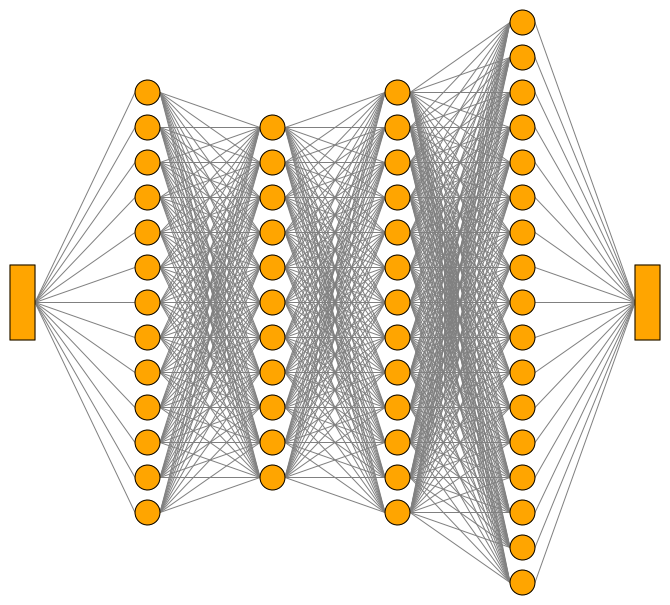

In [35]:
visualkeras.graph_view(model,node_size=25,layer_spacing=100,ellipsize_after=20)

In [36]:
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy'])

In [37]:
try:
    model.fit(x_train,x_train,
              epochs=100,batch_size=4096,
              callbacks=[backup_callback,tensorboard_callback]
              )

except:
    pass

Epoch 1/100
2010/2010 [==============================] - 6s 3ms/step - loss: 0.0243 - accuracy: 0.1996
Epoch 2/100
2010/2010 [==============================] - 6s 3ms/step - loss: 0.0058 - accuracy: 0.1623
Epoch 3/100
2010/2010 [==============================] - 6s 3ms/step - loss: 0.0032 - accuracy: 0.1991
Epoch 4/100
2010/2010 [==============================] - 6s 3ms/step - loss: 0.0025 - accuracy: 0.2616
Epoch 5/100
2010/2010 [==============================] - 6s 3ms/step - loss: 0.0023 - accuracy: 0.2590
Epoch 6/100
2010/2010 [==============================] - 6s 3ms/step - loss: 0.0022 - accuracy: 0.2676
Epoch 7/100
2010/2010 [==============================] - 6s 3ms/step - loss: 0.0022 - accuracy: 0.2737
Epoch 8/100
2010/2010 [==============================] - 6s 3ms/step - loss: 0.0022 - accuracy: 0.2759
Epoch 9/100
2010/2010 [==============================] - 6s 3ms/step - loss: 0.0020 - accuracy: 0.2873
Epoch 10/100
2010/2010 [==============================] - 6s 3ms/step - l

In [38]:
pred_set = dtset.copy()
reconstructed = model.predict(pred_set.T[:-2].T,batch_size = 4096,verbose=True)

4018/4018 [==============================] - 5s 1ms/step


In [39]:
key_dict = dtset.keys()

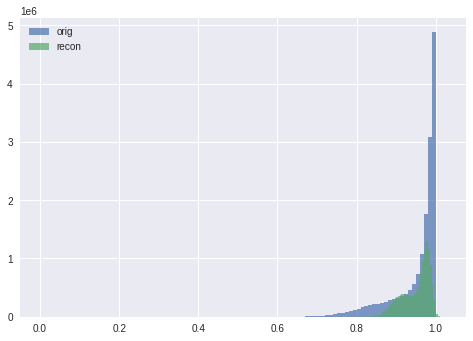

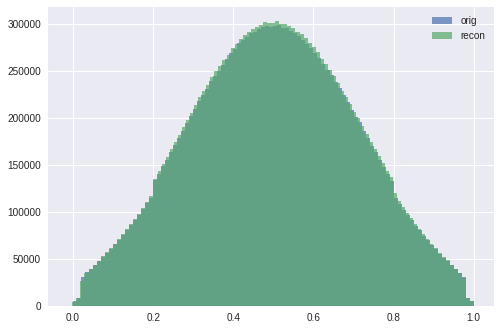

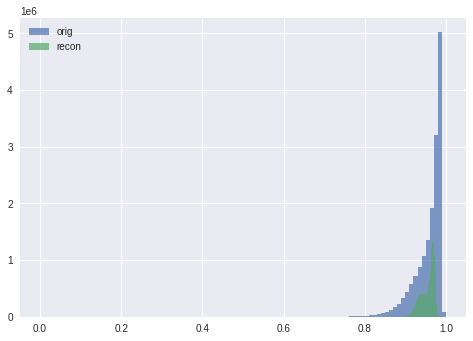

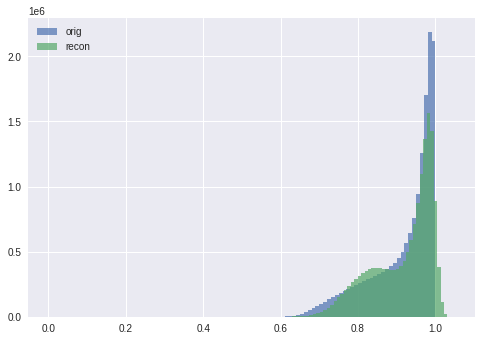

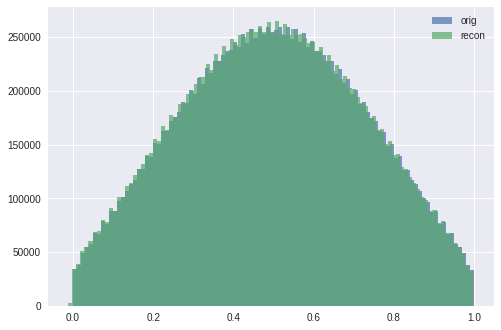

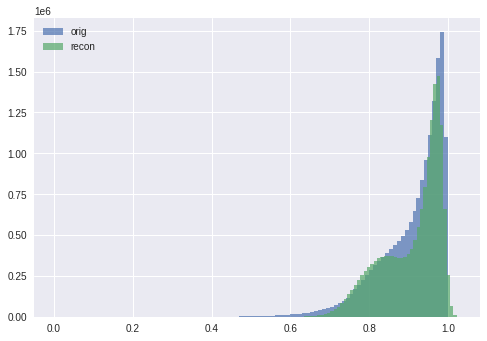

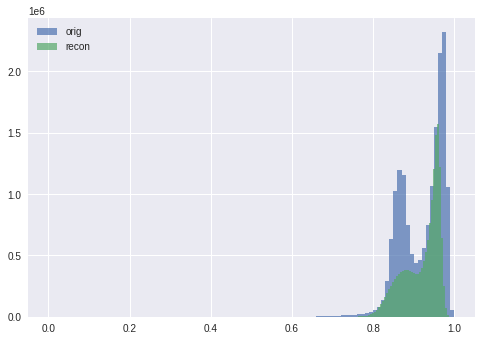

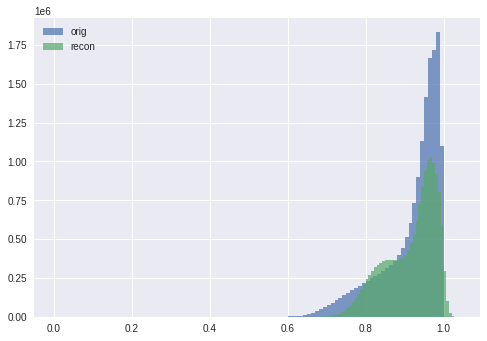

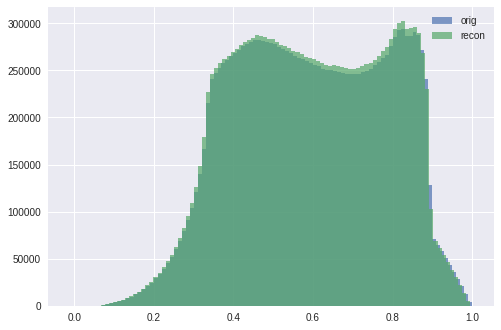

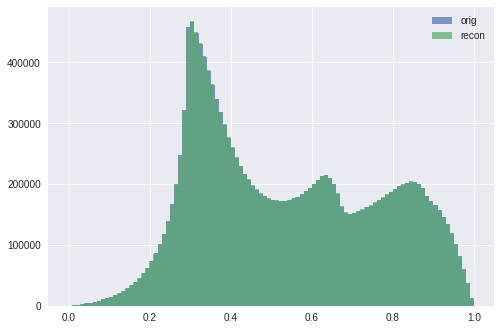

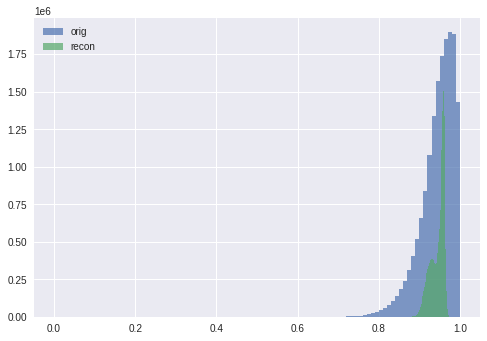

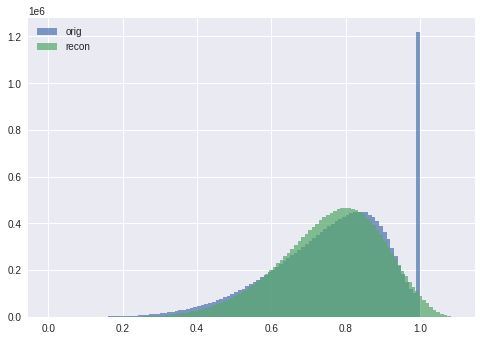

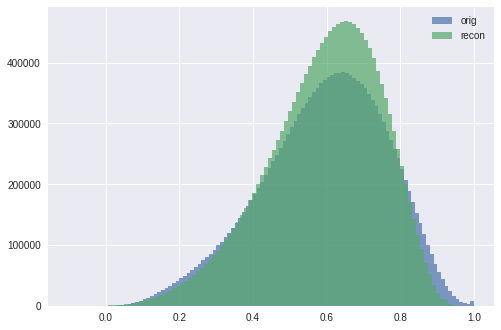

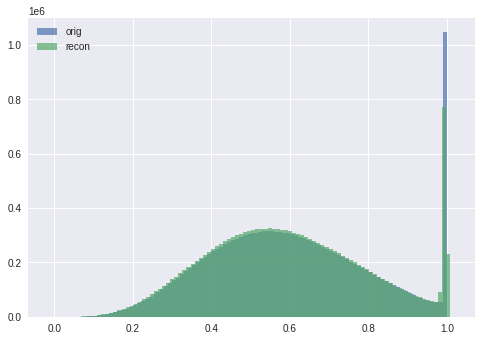

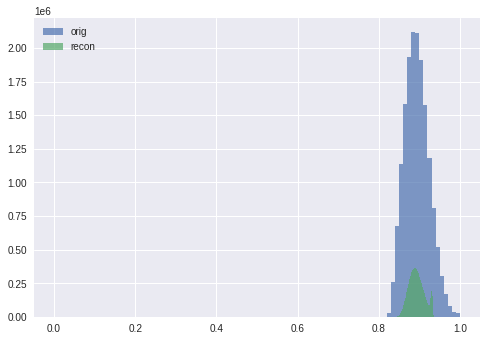

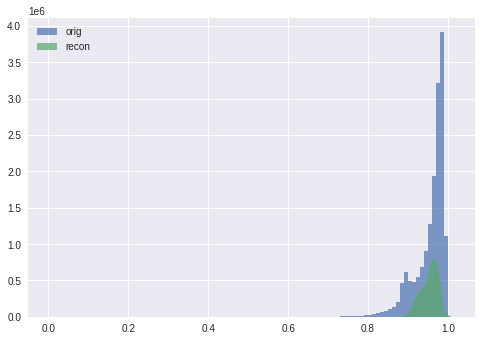

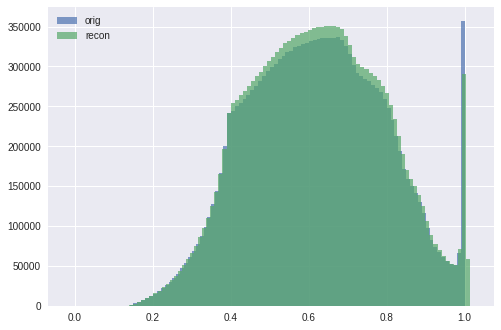

In [40]:
for i in range(17):
    plt.hist(dtset[key_dict[i]],bins=100,alpha=0.7)
    plt.hist(reconstructed.T[i],bins=100,alpha=0.7)
    plt.legend(['orig','recon'])
    plt.show()

In [41]:
for i in range(17):
    print(i,max(reconstructed.T[i]))

0 1.025979
1 1.0007365
2 0.9966738
3 1.0488926
4 0.9972036
5 1.0303975
6 0.99658
7 1.0420544
8 1.0046564
9 1.0001568
10 0.9760349
11 1.0925416
12 0.98460937
13 1.0188408
14 0.93781
15 1.0160248
16 1.0243218
